In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, binom, beta
import math
!pip install pymc3
import pymc3 as pm
import arviz as az

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 13.7 MB/s 
     |████████████████████████████████| 1.8 MB 36.2 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=b8313b55b875de9a75eaa4acc0b5679891091b60d81d1426f3049308144329bf
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [36]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    domain = np.linspace(0,.99,n)
    sample = np.random.binomial(n,p) # see how many successes you get
    L = binom.pmf(sample, n, domain) # calculate the likelihood
    L = L/np.trapz(L,domain) # normalize it
    plt.plot(domain,L) 
    plt.title('Plot for p={}'.format(p))
    plt.show()
    return domain[np.argmax(L)]

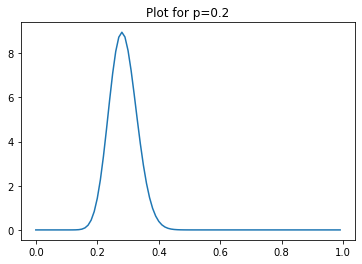

0.28

In [37]:
bernoulli_sampling(.2,100)

In [42]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    domain = np.linspace(0,.99,n) #domain corrected for linspace
    sample = np.random.binomial(n,p) #sample from binomial
    num = binom.pmf(sample, n, domain)*prior.pdf(domain) #numerator of posterior
    denom = sum(num) / n #denominator approx of posterior
    posterior = num / denom #compute posterior
    plt.plot(domain,posterior)
    plt.title('Plot for p={}'.format(p))
    plt.show()
    return domain[np.argmax(posterior)] #MAP estimate

Text(0.5, 1.0, 'Plot of the Prior')

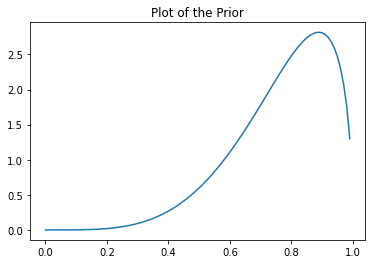

In [40]:
domain = np.linspace(0,.99,100)
plt.plot(domain,beta(5,1.5).pdf(domain))
plt.title('Plot of the Prior')

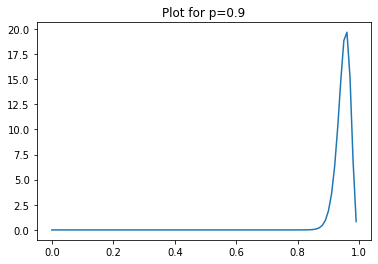

0.96

In [43]:
non_uniform_prior(.9,100,beta(5,1.5))

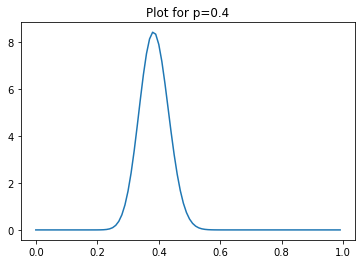

0.38

In [44]:
non_uniform_prior(.4,100,beta(5,1.5))

In [45]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. Return a list of strings, not including the 0th day.
    """
    choice = np.random.choice(transition_matrix.shape[0],p=transition_matrix[0,:])
    C = []
    weather = {0:'sun',1:'rain',2:'wind'}
    C.append(choice)
    for i in range(days - 1):
        choice = np.random.choice(transition_matrix.shape[0],p=transition_matrix[int(choice),:])
        C.append(choice)
    C = np.array(C)
    forecast = []
    for j in range(len(C)):
        forecast.append(weather[C[j]])
    return forecast
    

In [46]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

weather_forecast(transition_matrix)

['sun', 'wind', 'rain', 'wind', 'rain', 'sun', 'sun', 'sun', 'sun', 'sun']

In [47]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Plot the trace plot and return the expected value of
    the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    model = pm.Model()
    with model:
        # define the prior of lambda as a gamma(2, 2) distribution
        p1 = pm.Beta('p', alpha=1, beta=1)
        # define the likelihood of the data (called nacho_data) to be distributed
        # as Poisson where the expected value of the outcome (mu) is lam
        y = pm.Bernoulli('y', p=p1, observed=data)
        # sample from the posterior
        trace = pm.sample(n) # n is the desired number of samples
        az.plot_trace(trace) # plot the posterior and trace plot for lambda
        new_p = trace['p'] # trace values of lambda as a list
        mean = new_p.mean() # expected value of lambda
    return mean


/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


0.22412418279540786

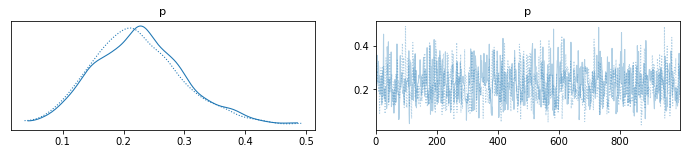

In [28]:
data = bernoulli.rvs(0.2, size=30)

posterior_sampling(data)

In [29]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):
    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu, 1/tau) where mu has a prior of Normal(m, s), 
    and tau has a prior of Gamma(alpha, beta). Set up a PyMC3 model for this 
    situation and sample from the poterior n times. Plot the trace plots for 
    mu and tau, and return the expected value of the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    model = pm.Model()
    with model:
        # define the prior of lambda as a gamma(2, 2) distribution
        mu = pm.Normal('mu', mu=m, sigma=s)
        # define the likelihood of the data (called nacho_data) to be distributed
        # as Poisson where the expected value of the outcome (mu) is lam
        tau = pm.Gamma('tau', alpha, beta)
        y = pm.Normal('y', mu, 1/tau, observed=observed_heights)
        # sample from the posterior
        trace = pm.sample(n) # n is the desired number of samples
        az.plot_trace(trace) # plot the posterior and trace plot for lambda
        plt.tight_layout()
        new_mu = trace['mu'] # trace values of lambda as a list
        mean = new_mu.mean() # expected value of lambda
    return mean

/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


180.98501448821054

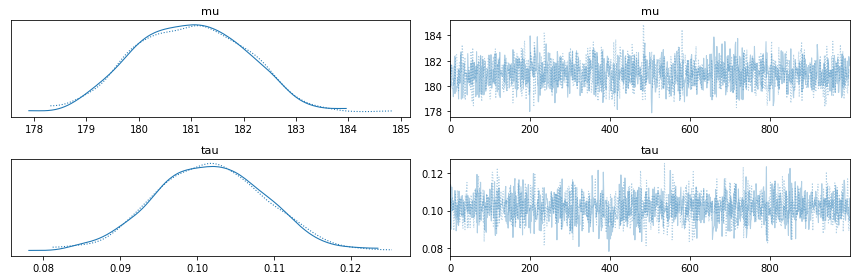

In [30]:
heights = np.random.normal(180,10,100)

height_model(heights)